# Overview

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import spacy
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date
from catboost import Pool, CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import holidays
from itertools import product
from xgboost import plot_importance


rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
item_categories = pd.read_csv("./data/item_categories.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [7]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



# Preprocessing

## train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


### Format: date

In [4]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [5]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [6]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

### Date aggregation

In [7]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


## test

In [20]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")

The number of shops in train data: 60
The number of shops in test data: 42


In [21]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


363

## shop

According to discussion in kaggle, some shops are similar to each other possibly due to re-opening. 

In [8]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

# Feature Engineering

## Text Embeddings

In [9]:
ru_model = KeyedVectors.load_word2vec_format('../wiki.ru.vec')

In [10]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features

In [11]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

### item_categories

In [12]:
item_categories_feature = extract_feature(item_categories['item_category_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 281.08it/s]

Max: 1800
Failed: 1


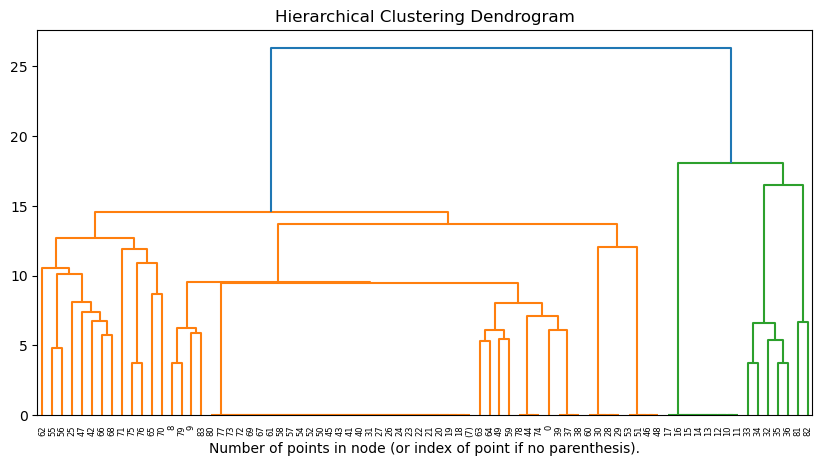

In [13]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(item_categories_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [14]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 17
Check the shape of labels: 84
Labels: [ 2  6  6  6  6  6  6  6  5  5 11 11 11 11 11 11 11 11  6  6  6  6  6  6
  6 15  6  6 16 16 16  6  3  3  3  3  3  2  2  2  6  6  0  6  2  6  9  0
  9  7  6  9  6  9  6 12 12  6  6  7 16  6 10  7  7 14  0  6  0  6 13  8
  6  6  2  4  4  6  2  5  6  1  1  5]


In [15]:
item_categories['item_category_te'] = clustering.labels_
item_categories = item_categories.drop(columns=['item_category_name'])
item_categories

,item_category_id,item_category_te
0,0,2
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
79,79,5
80,80,6
81,81,1
82,82,1


In [16]:
cols = ["category_1", "category_2"]
item_categories_tfidf = pd.read_csv("./sales/_item_categories.csv", 
                                    usecols=["item_category_id", "category_1", "category_2"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(item_categories_tfidf[col].unique()))
    item_categories_tfidf = item_categories_tfidf.replace({col:value_map})

item_categories_tfidf.head()

,item_category_id,category_1,category_2
0,0,0,0
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4


### shops

In [17]:
shops_feature = extract_feature(shops['shop_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 310.19it/s]

Max: 1500
Failed: 2


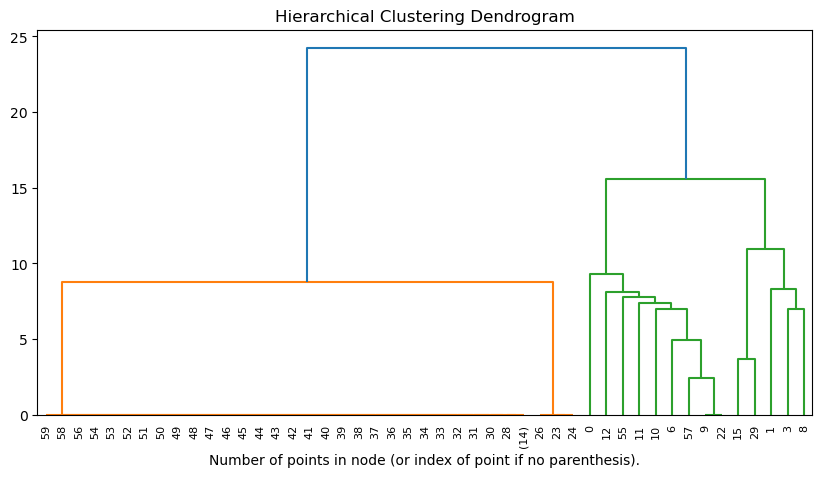

In [18]:
clustering = AgglomerativeClustering(distance_threshold=5, n_clusters=None).fit(shops_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [19]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 12
Check the shape of labels: 60
Labels: [ 9  6  5 11  5  5  0  5  8  0 10  4  7  5  5  1  5  5  5  5  5  5  0  2
  2  5  2  5  5  1  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  3  5  0  5  5]


In [20]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [21]:
shops['city'] = encoding_cate(shop_city, 0)
shops['info'] = encoding_cate(shop_info, 1)
shops['shop_te'] = clustering.labels_
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 32
The number of classes: 7


,shop_id,city,info,shop_te
0,0,30,2,9
1,1,30,6,6
2,2,10,6,5
3,3,2,4,11
4,4,3,6,5


In [22]:
cols = ["shop_kind", "city", "shop_brand"]
shops_tfidf = pd.read_csv("./sales/_shops.csv", usecols=["shop_id", "shop_kind", "city", "shop_brand"])

for col in cols:
    value_map = dict((v,i) for i,v in enumerate(shops_tfidf[col].unique()))
    shops_tfidf = shops_tfidf.replace({col:value_map})

shops_tfidf = shops_tfidf.rename(columns={'city': 'city2'})
shops_tfidf.head()

,shop_id,city2,shop_kind,shop_brand
0,0,0,0,0
1,1,0,1,1
2,2,1,1,2
3,3,2,2,3
4,4,3,1,4


### items

In [23]:
# The first word in item name
first_word = items['item_name'].str.split(pat=' ').apply(lambda x: x[0])
first_word = encoding_cate(first_word, 3)

The number of classes: 1224


In [24]:
# Information about the item in ()
def trans_lst(col):
    if len(col) > 0:
        item = col[0]
        item = item.lower()
        item = re.sub("\s", "", item)
        item = item.strip("\[\s\t\n")
    else:
        item = ""
    return item

item_addons = items['item_name'].str.findall(r'\((.+?)\)').apply(trans_lst)
item_addons = encoding_cate(item_addons, 5)

The number of classes: 116


In [25]:
# Information about the item in []
item_addons_2 = items['item_name'].str.findall(r'\[(.+?)[,\]...]').apply(trans_lst)
item_addons_2 = encoding_cate(item_addons_2, 10)

The number of classes: 14


In [26]:
items['first_word'] = first_word
items['item_addons'] = item_addons
items['item_addons_2'] = item_addons_2
items = items.drop(columns=['item_name'])
items

,item_id,item_category_id,first_word,item_addons,item_addons_2
0,0,40,0,0,13
1,1,76,0,115,12
2,2,40,0,0,13
3,3,40,0,0,13
4,4,40,0,38,13
...,...,...,...,...,...
22165,22165,31,0,115,12
22166,22166,54,0,115,9
22167,22167,49,0,81,13
22168,22168,62,0,115,13


In [27]:
# items_tfidf = pd.read_csv("./sales/items.csv")
# feature_count = 25
# tfidf = TfidfVectorizer(max_features=feature_count)
# items_df_item_name_text_features = tfidf.fit_transform(items_tfidf['item_name']).toarray().tolist()
# items_tfidf["item_names_tf_idf"] = items_df_item_name_text_features
# items_tfidf.drop('item_name', axis = 1, inplace = True)
# items_tfidf

## Structural Embeddings

### Date

In [27]:
holiday = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().apply(lambda x: int(x in holidays.Russia()))
holiday = holiday.to_frame('check').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(holiday['index'].dt.year.unique().tolist(), 
                                holiday['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]

holiday['date_block_num'] = holiday['index'].apply(map_date_block_num)
holiday = holiday.groupby(by='date_block_num')['check'].sum().to_frame('n_holidays').reset_index()

In [28]:
day_of_week = pd.date_range(start='2013-01-01', end='2015-11-30').to_series().dt.isocalendar().day.to_frame('day').reset_index()

def map_date_block_num(col):
    block = dict(list(enumerate(product(day_of_week['index'].dt.year.unique().tolist(), 
                                day_of_week['index'].dt.month.unique().tolist()))))
    block = {v: k for k, v in block.items()}
    key = (col.year, col.month)
    return block[key]
day_of_week['date_block_num'] = day_of_week['index'].apply(map_date_block_num)
for i in range(1, 8):
    day_of_week[f'day_{i}'] = (day_of_week['day'] == i).astype(int)
    
day_of_week = day_of_week.drop(columns=['index', 'day']).groupby(by=['date_block_num']).sum().reset_index()

In [29]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['daysinmonth'] = train['date'].dt.daysinmonth
train['is_busday'] = np.is_busday(train['date'].dt.date.tolist()).astype(int)
train_busdays = train.loc[:, ['date', 'date_block_num', 'is_busday']].drop_duplicates()
train = train.merge(train_busdays.groupby(by=['date_block_num'])['is_busday'].sum().to_frame('n_busdays'),
                    on='date_block_num',
                    how='left')
date_meta = train.drop(columns=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'is_busday'])
date_meta = date_meta.drop_duplicates()

In [30]:
train_g = train_g.merge(holiday, on='date_block_num', how='left')
train_g = train_g.merge(day_of_week, on='date_block_num', how='left')
train_g = train_g.merge(date_meta, on=['date_block_num'], how='left')
train_g

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7,year,month,quarter,daysinmonth,n_busdays
0,0,0,32,6.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
1,0,0,33,3.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
2,0,0,35,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
3,0,0,43,1.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
4,0,0,51,2.0,8,4,5,5,5,4,4,4,2013,1,1,31,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
1609120,33,59,22088,2.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
1609121,33,59,22091,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22
1609122,33,59,22100,1.0,0,4,4,4,5,5,5,4,2015,10,4,31,22


In [31]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test['quarter'] = 4
test['daysinmonth'] = 30
test['n_busdays'] = np.busday_count('2015-11', '2015-12')
test = test.merge(holiday, on='date_block_num', how='left')
test = test.merge(day_of_week, on='date_block_num', how='left')
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,0,5,5037,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
1,1,5,5320,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
2,2,5,5233,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
3,3,5,5232,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
4,4,5,5268,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214196,214196,45,16188,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214197,214197,45,15757,34,2015,11,4,30,21,1,5,4,4,4,4,4,5
214198,214198,45,19648,34,2015,11,4,30,21,1,5,4,4,4,4,4,5


### Price

In [32]:
# price median
price_med = train.loc[:, ['item_id', 'item_price']].groupby(by=['item_id']).median().reset_index()
price_med = price_med.rename(columns={'item_price': 'item_price_med'})
train = train_g.merge(price_med, on='item_id', how='left')
test = test.merge(price_med, on='item_id', how='left')

In [33]:
# price date median
price_med_date = train.loc[:, ['date_block_num', 'item_id', 'item_price_med']]
price_med_date = price_med_date.groupby(by=['date_block_num', 'item_id']).median().reset_index()
price_med_date = price_med_date.rename(columns={'item_price_med': 'item_price_med_date'})
train = train_g.merge(price_med_date, on=['date_block_num', 'item_id'], how='left')
test = test.merge(price_med_date, on=['date_block_num', 'item_id'], how='left')

In [34]:
# price-item lag
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_price_med_date']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_id']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_price_med_date': f'item_price_med_date_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [35]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,daysinmonth,n_busdays,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12
0,0,0,32,6.0,8,4,5,5,5,4,...,31,23,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,8,4,5,5,5,4,...,31,23,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,8,4,5,5,5,4,...,31,23,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,8,4,5,5,5,4,...,31,23,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,8,4,5,5,5,4,...,31,23,249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,...,31,22,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
1609120,33,59,22088,2.0,0,4,4,4,5,5,...,31,22,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
1609121,33,59,22091,1.0,0,4,4,4,5,5,...,31,22,109.0,109.0,NaN,NaN,NaN,NaN,NaN,109.0
1609122,33,59,22100,1.0,0,4,4,4,5,5,...,31,22,629.0,629.0,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,day_7,item_price_med,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12
0,0,5,5037,34,2015,11,4,30,21,1,...,5,1999.0,NaN,NaN,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0
1,1,5,5320,34,2015,11,4,30,21,1,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,34,2015,11,4,30,21,1,...,5,599.5,NaN,599.5,599.5,599.5,NaN,599.5,599.5,NaN
3,3,5,5232,34,2015,11,4,30,21,1,...,5,599.5,NaN,NaN,NaN,599.5,NaN,NaN,NaN,NaN
4,4,5,5268,34,2015,11,4,30,21,1,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,5,199.0,NaN,199.0,NaN,NaN,NaN,NaN,NaN,NaN
214196,214196,45,16188,34,2015,11,4,30,21,1,...,5,1223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,34,2015,11,4,30,21,1,...,5,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214198,214198,45,19648,34,2015,11,4,30,21,1,...,5,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Release Date

In [37]:
release = pd.concat([train_g.loc[:, ['date_block_num', 'item_id']],
                    test.loc[:, ['date_block_num', 'item_id']]])
release = release.groupby(by=['item_id']).min().reset_index()
release = release.rename(columns={'date_block_num': 'release_date'})
train = train.merge(release, on='item_id', how='left')
test = test.merge(release, on='item_id', how='left')

In [38]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,n_busdays,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12,release_date
0,0,0,32,6.0,8,4,5,5,5,4,...,23,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,0,33,3.0,8,4,5,5,5,4,...,23,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,0,35,1.0,8,4,5,5,5,4,...,23,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,0,43,1.0,8,4,5,5,5,4,...,23,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,0,51,2.0,8,4,5,5,5,4,...,23,249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,...,22,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,0
1609120,33,59,22088,2.0,0,4,4,4,5,5,...,22,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,0
1609121,33,59,22091,1.0,0,4,4,4,5,5,...,22,109.0,109.0,NaN,NaN,NaN,NaN,NaN,109.0,0
1609122,33,59,22100,1.0,0,4,4,4,5,5,...,22,629.0,629.0,NaN,NaN,NaN,NaN,NaN,NaN,30


In [39]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,item_price_med,item_price_med_date,item_price_med_date_lag1,item_price_med_date_lag2,item_price_med_date_lag3,item_price_med_date_lag4,item_price_med_date_lag5,item_price_med_date_lag6,item_price_med_date_lag12,release_date
0,0,5,5037,34,2015,11,4,30,21,1,...,1999.0,NaN,NaN,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,20
1,1,5,5320,34,2015,11,4,30,21,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
2,2,5,5233,34,2015,11,4,30,21,1,...,599.5,NaN,599.5,599.5,599.5,NaN,599.5,599.5,NaN,27
3,3,5,5232,34,2015,11,4,30,21,1,...,599.5,NaN,NaN,NaN,599.5,NaN,NaN,NaN,NaN,31
4,4,5,5268,34,2015,11,4,30,21,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,199.0,NaN,199.0,NaN,NaN,NaN,NaN,NaN,NaN,23
214196,214196,45,16188,34,2015,11,4,30,21,1,...,1223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
214197,214197,45,15757,34,2015,11,4,30,21,1,...,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
214198,214198,45,19648,34,2015,11,4,30,21,1,...,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23


### Sales Lag

In [40]:
# item sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'item_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'item_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'item_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'item_id'], how='left')

In [41]:
# Merge
train = train.merge(items, on='item_id', how='left')
test = test.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')
test = test.merge(item_categories, on='item_category_id', how='left')
train = train.merge(item_categories_tfidf, on='item_category_id', how='left')
test = test.merge(item_categories_tfidf, on='item_category_id', how='left')
train = train.merge(shops, on='shop_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
train = train.merge(shops_tfidf, on='shop_id', how='left')
test = test.merge(shops_tfidf, on='shop_id', how='left')
# train = train.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')
# test = test.merge(items_tfidf, on=['item_id', 'item_category_id'], how='left')

In [42]:
# item-shop mean
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_id']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'item_shop_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [43]:
# shop sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'shop_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id'], how='left')

In [44]:
# city sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'city', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'city']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'city_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'city'], how='left')
    test = test.merge(sales, on=['date_block_num', 'city'], how='left')

In [45]:
# category sum
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'item_category_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'item_category_id']).sum().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'item_category_id_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'item_category_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'item_category_id'], how='left')

In [46]:
# shop category mean
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_category_id', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_category_id']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'shop_cat_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

In [47]:
# shop category_te mean
for lag in [1, 2, 3, 4, 5, 6, 12]:
    sales = train.loc[:, ['date_block_num', 'shop_id', 'item_category_te', 'item_cnt_month']]
    sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_category_te']).mean().reset_index()
    sales['date_block_num'] = sales['date_block_num'] + lag
    sales = sales.rename(columns={'item_cnt_month': f'shop_cat_te_sales_lag{lag}'})
    sales = sales[sales['date_block_num'] <= 34]
    train = train.merge(sales, on=['date_block_num', 'shop_id', 'item_category_te'], how='left')
    test = test.merge(sales, on=['date_block_num', 'shop_id', 'item_category_te'], how='left')

In [48]:
train

,date_block_num,shop_id,item_id,item_cnt_month,n_holidays,day_1,day_2,day_3,day_4,day_5,...,shop_cat_sales_lag5,shop_cat_sales_lag6,shop_cat_sales_lag12,shop_cat_te_sales_lag1,shop_cat_te_sales_lag2,shop_cat_te_sales_lag3,shop_cat_te_sales_lag4,shop_cat_te_sales_lag5,shop_cat_te_sales_lag6,shop_cat_te_sales_lag12
0,0,0,32,6.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,8,4,5,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,0,4,4,4,5,5,...,2.5,2.5,4.0,4.750,6.500000,12.000000,5.0,6.0,8.0,6.333333
1609120,33,59,22088,2.0,0,4,4,4,5,5,...,2.5,2.5,4.0,4.750,6.500000,12.000000,5.0,6.0,8.0,6.333333
1609121,33,59,22091,1.0,0,4,4,4,5,5,...,2.5,2.5,4.0,4.750,6.500000,12.000000,5.0,6.0,8.0,6.333333
1609122,33,59,22100,1.0,0,4,4,4,5,5,...,NaN,NaN,NaN,1.375,1.333333,1.333333,1.0,NaN,NaN,NaN


In [49]:
test

,ID,shop_id,item_id,date_block_num,year,month,quarter,daysinmonth,n_busdays,n_holidays,...,shop_cat_sales_lag5,shop_cat_sales_lag6,shop_cat_sales_lag12,shop_cat_te_sales_lag1,shop_cat_te_sales_lag2,shop_cat_te_sales_lag3,shop_cat_te_sales_lag4,shop_cat_te_sales_lag5,shop_cat_te_sales_lag6,shop_cat_te_sales_lag12
0,0,5,5037,34,2015,11,4,30,21,1,...,1.820513,1.923077,1.878049,1.639286,1.683333,1.687003,1.433121,1.536765,1.656604,1.840336
1,1,5,5320,34,2015,11,4,30,21,1,...,1.173469,1.213483,1.178571,1.186813,1.142857,1.180328,1.156863,1.170000,1.219780,1.178571
2,2,5,5233,34,2015,11,4,30,21,1,...,1.820513,1.923077,1.878049,1.639286,1.683333,1.687003,1.433121,1.536765,1.656604,1.840336
3,3,5,5232,34,2015,11,4,30,21,1,...,1.636364,1.593750,1.717391,1.639286,1.683333,1.687003,1.433121,1.536765,1.656604,1.840336
4,4,5,5268,34,2015,11,4,30,21,1,...,2.409091,3.583333,5.925926,1.639286,1.683333,1.687003,1.433121,1.536765,1.656604,1.840336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,4,30,21,1,...,1.129630,1.289855,1.347826,1.205479,1.113636,1.161290,1.243243,1.140351,1.295775,1.385417
214196,214196,45,16188,34,2015,11,4,30,21,1,...,1.100000,1.000000,1.230769,1.193548,1.192308,1.256410,1.638889,1.100000,1.105263,1.225000
214197,214197,45,15757,34,2015,11,4,30,21,1,...,1.129630,1.289855,1.347826,1.205479,1.113636,1.161290,1.243243,1.140351,1.295775,1.385417
214198,214198,45,19648,34,2015,11,4,30,21,1,...,1.340909,1.229508,1.391304,1.470588,1.587678,1.339130,1.331579,1.389744,1.452381,1.836735


In [50]:
# Check missing values
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

train:
date_block_num                  0
shop_id                         0
item_id                         0
item_cnt_month                  0
n_holidays                      0
                            ...  
shop_cat_te_sales_lag3     210548
shop_cat_te_sales_lag4     269582
shop_cat_te_sales_lag5     327867
shop_cat_te_sales_lag6     387489
shop_cat_te_sales_lag12    736316
Length: 88, dtype: int64

test:
ID                             0
shop_id                        0
item_id                        0
date_block_num                 0
year                           0
                           ...  
shop_cat_te_sales_lag3     12577
shop_cat_te_sales_lag4     12496
shop_cat_te_sales_lag5     12888
shop_cat_te_sales_lag6     13770
shop_cat_te_sales_lag12    18568
Length: 89, dtype: int64



In [51]:
train = train.fillna(0)
test = test.fillna(0)

In [52]:
# Prepare train/test data
train_y = train['item_cnt_month'].clip(0, 20)
train = train.drop(columns=['item_cnt_month'])
# train = train.drop(columns=['item_names_tf_idf'])
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 87 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   date_block_num                1609124 non-null  int64  
 1   shop_id                       1609124 non-null  int64  
 2   item_id                       1609124 non-null  int64  
 3   n_holidays                    1609124 non-null  int64  
 4   day_1                         1609124 non-null  int64  
 5   day_2                         1609124 non-null  int64  
 6   day_3                         1609124 non-null  int64  
 7   day_4                         1609124 non-null  int64  
 8   day_5                         1609124 non-null  int64  
 9   day_6                         1609124 non-null  int64  
 10  day_7                         1609124 non-null  int64  
 11  year                          1609124 non-null  int64  
 12  month                       

In [53]:
test = test.drop(columns=['ID'])#, 'item_names_tf_idf'])
test = test[train.columns.tolist()]
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 87 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_block_num                214200 non-null  int64  
 1   shop_id                       214200 non-null  int64  
 2   item_id                       214200 non-null  int64  
 3   n_holidays                    214200 non-null  int64  
 4   day_1                         214200 non-null  int64  
 5   day_2                         214200 non-null  int64  
 6   day_3                         214200 non-null  int64  
 7   day_4                         214200 non-null  int64  
 8   day_5                         214200 non-null  int64  
 9   day_6                         214200 non-null  int64  
 10  day_7                         214200 non-null  int64  
 11  year                          214200 non-null  int64  
 12  month                         214200 non-nul

In [54]:
train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")
train_y.to_pickle("./data/train_y.pkl")

# Models

## ARIMA

### Example

In [15]:
trial = train.groupby(by=["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame(name='item_cnt_month').reset_index()
trial = trial.set_index('date_block_num')
trial

,shop_id,item_cnt_month
date_block_num,,
0,2,1151.0
0,3,767.0
0,4,2117.0
0,6,3699.0
0,7,2498.0
...,...,...
33,55,1972.0
33,56,1267.0
33,57,2319.0


In [34]:
# Auto ARIMA：Example
trial_ex = trial[trial['shop_id'] == 2].drop(columns=['shop_id'])
model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -232.960
Date:                Mon, 28 Nov 2022   AIC                            471.921
Time:                        23:34:17   BIC                            476.500
Sample:                             0   HQIC                           473.482
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    636.9515    194.972      3.267      0.001     254.813    1019.090
ar.L1          0.2947      0.184      1.601      0.109      -0.066       0.656
sigma2        5.2e+04   8361.650      6.219      0.000    3.56e+04    6.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                80.69
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.89
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

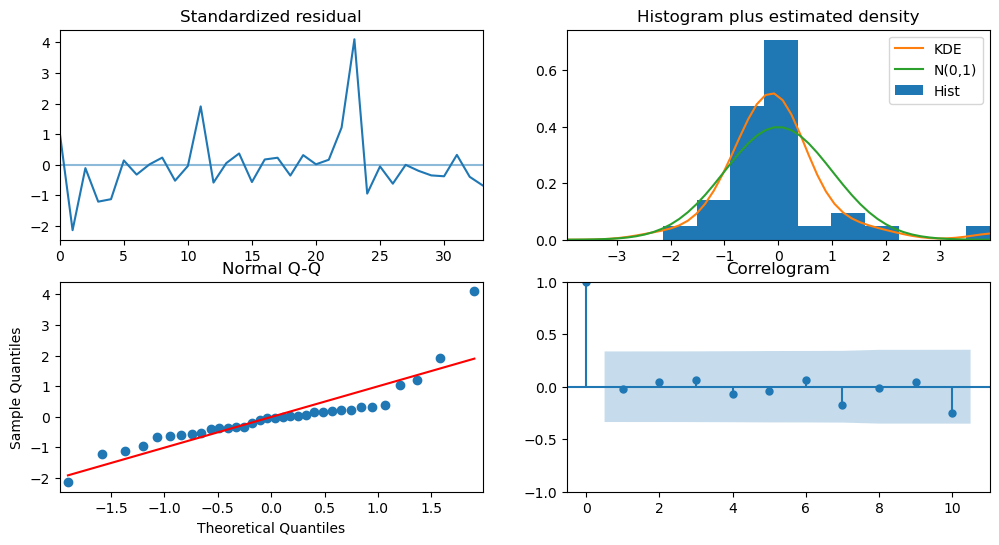

In [35]:
with plt.rc_context():
    plt.rc("figure", figsize=(12, 6))
    model.plot_diagnostics()
    plt.show()

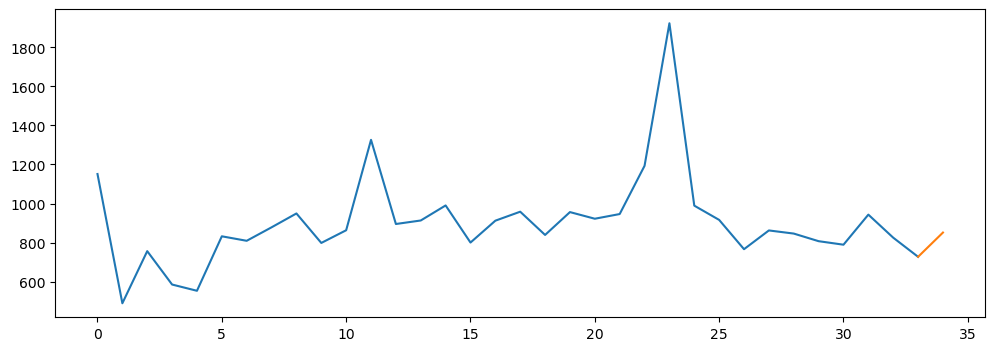

In [50]:
forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))

with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(trial_ex.shape[0]), trial_ex['item_cnt_month'])
    plt.plot(range(trial_ex.shape[0] - 1, trial_ex.shape[0] + 34 - trial_ex.index[-1]), 
             [trial_ex['item_cnt_month'].iloc[-1], forecast.iloc[-1]])
    plt.show()

### Prediction

In [31]:
shop_lst = train['shop_id'].unique().tolist()
train_origin = pd.read_csv("./data/sales_train.csv")
per = train_origin.groupby(by=["item_id"])["item_cnt_day"].sum().to_frame(name='item_cnt').reset_index()
col = per["item_cnt"].copy()
per["item_per"] = col / col.sum()
pre_df  = pd.DataFrame(columns=["shop_id", "item_id", "item_cnt_month"])

for i in range(len(shop_lst)):
    trial_ex = trial[trial['shop_id'] == shop_lst[i]].drop(columns=['shop_id'])
    model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
    forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))
    try:
        forecast = forecast.iloc[-1]
    except:
        forecast = trial_ex.iloc[0, -1]
    per_example = per[per['item_id'].isin(test.loc[(test['shop_id'] == shop_lst[i]), 'item_id'].unique().tolist())]
    per_example['item_cnt_month'] = per_example['item_per'] * forecast
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] > 20, 20, per_example['item_cnt_month'])
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] < 0, 0, per_example['item_cnt_month'])
    per_example['shop_id'] = shop_lst[i]
    per_example = per_example.drop(columns=["item_per", "item_cnt"])
    pre_df = pd.concat([pre_df, per_example], axis=0)
    
pre_df

/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

,shop_id,item_id,item_cnt_month
30,59,30,0.453507
31,59,31,0.311528
32,59,32,0.454159
33,59,33,0.181490
38,59,38,0.014328
...,...,...,...
21799,36,22162,0.063803
21800,36,22163,0.006846
21801,36,22164,0.045000
21803,36,22166,0.031765


In [35]:
test_arima = pd.merge(test, pre_df, on=['shop_id', 'item_id'], how = "left")
test_arima = test_arima.fillna(value=test_arima['item_cnt_month'].mean())
# test_arima = test_arima.fillna(0)
test_arima 

,ID,shop_id,item_id,item_category_id,date_block_num,price_m,item_cnt_month
0,0,5,5037,19,34,1499.000000,0.428533
1,1,5,5320,55,34,445.207669,0.000000
2,2,5,5233,19,34,1199.000000,0.171076
3,3,5,5232,23,34,1190.433333,0.047577
4,4,5,5268,20,34,445.207669,0.000000
...,...,...,...,...,...,...,...
214195,214195,45,18454,55,34,99.000000,0.087680
214196,214196,45,16188,64,34,1359.000000,0.000678
214197,214197,45,15757,55,34,229.000000,0.062750
214198,214198,45,19648,40,34,89.100000,0.009497


In [36]:
test_arima.isna().sum()

ID                  0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
price_m             0
item_cnt_month      0
dtype: int64

In [37]:
test_arima = test_arima.loc[:, ['ID', 'item_cnt_month']]
test_arima.to_csv('./results/submission_4.csv', index=False)

## Model Stacking

In [3]:
train = pd.read_pickle("./data/train.pkl")
test = pd.read_pickle("./data/test.pkl")
train_y = pd.read_pickle("./data/train_y.pkl")

In [4]:
X_tr = train[train['date_block_num'] < 33]
X_va = train[train['date_block_num'] == 33]
index = X_tr.shape[0]
y_tr = train_y[:index]
y_va = train_y[index:]

In [5]:
# CatBoost 
train_pool = Pool(X_tr, y_tr) 
val_pool = Pool(X_va, y_va) 

model = CatBoostRegressor(early_stopping_rounds=10)
model.fit(train_pool, early_stopping_rounds=10, eval_set=val_pool, use_best_model=True)
pred_va = model.predict(val_pool)
print(mean_squared_error(y_va, pred_va, squared=False))

Learning rate set to 0.161801
0:	learn: 2.4475878	test: 2.4348945	best: 2.4348945 (0)	total: 275ms	remaining: 4m 35s
1:	learn: 2.3424836	test: 2.3521060	best: 2.3521060 (1)	total: 500ms	remaining: 4m 9s
2:	learn: 2.2607078	test: 2.2879807	best: 2.2879807 (2)	total: 702ms	remaining: 3m 53s
3:	learn: 2.2003838	test: 2.2435346	best: 2.2435346 (3)	total: 876ms	remaining: 3m 38s
4:	learn: 2.1541543	test: 2.2103615	best: 2.2103615 (4)	total: 1.03s	remaining: 3m 25s
5:	learn: 2.1147251	test: 2.1841035	best: 2.1841035 (5)	total: 1.18s	remaining: 3m 16s
6:	learn: 2.0826550	test: 2.1629476	best: 2.1629476 (6)	total: 1.31s	remaining: 3m 5s
7:	learn: 2.0586165	test: 2.1485514	best: 2.1485514 (7)	total: 1.39s	remaining: 2m 52s
8:	learn: 2.0386366	test: 2.1365278	best: 2.1365278 (8)	total: 1.49s	remaining: 2m 43s
9:	learn: 2.0210409	test: 2.1232711	best: 2.1232711 (9)	total: 1.58s	remaining: 2m 36s
10:	learn: 2.0084359	test: 2.1167898	best: 2.1167898 (10)	total: 1.67s	remaining: 2m 30s
11:	learn: 1.

In [6]:
# XGBoost
model = xgb.XGBRegressor(n_estimators=5000, 
                         max_depth=10, 
                         early_stopping_rounds=10,
                         eval_metric="rmse",
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree=0.5)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=True)
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

[0]	validation_0-rmse:2.82349	validation_1-rmse:2.76839
[1]	validation_0-rmse:2.67270	validation_1-rmse:2.64500
[2]	validation_0-rmse:2.53891	validation_1-rmse:2.53574
[3]	validation_0-rmse:2.42498	validation_1-rmse:2.44038
[4]	validation_0-rmse:2.32685	validation_1-rmse:2.36287
[5]	validation_0-rmse:2.23957	validation_1-rmse:2.28635
[6]	validation_0-rmse:2.16526	validation_1-rmse:2.22183
[7]	validation_0-rmse:2.10305	validation_1-rmse:2.16932
[8]	validation_0-rmse:2.04658	validation_1-rmse:2.12782
[9]	validation_0-rmse:1.99465	validation_1-rmse:2.08540
[10]	validation_0-rmse:1.95432	validation_1-rmse:2.04788
[11]	validation_0-rmse:1.91554	validation_1-rmse:2.02410
[12]	validation_0-rmse:1.88490	validation_1-rmse:1.99878
[13]	validation_0-rmse:1.85700	validation_1-rmse:1.98141
[14]	validation_0-rmse:1.83243	validation_1-rmse:1.96476
[15]	validation_0-rmse:1.81225	validation_1-rmse:1.95454
[16]	validation_0-rmse:1.79161	validation_1-rmse:1.94884
[17]	validation_0-rmse:1.77528	validation

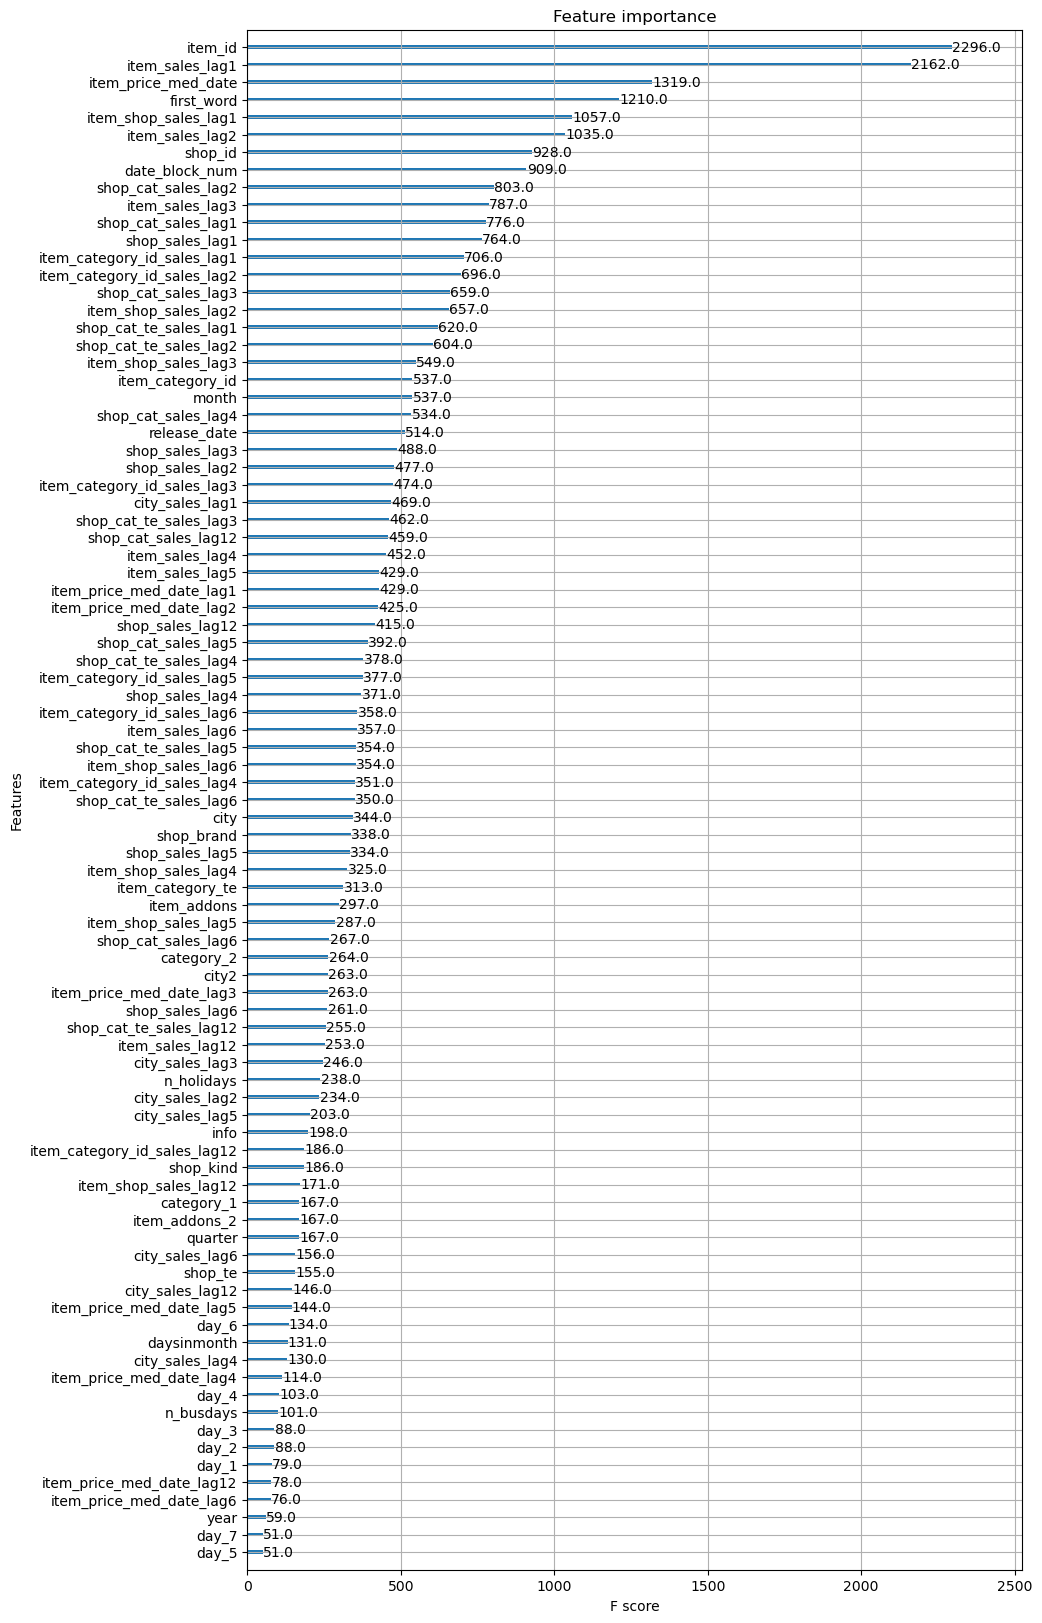

In [10]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10, 20))
plt.show()

In [16]:
# LightGBM
model = lgb.LGBMRegressor(n_estimators=5000, early_stopping_rounds=10)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=True, eval_metric='rmse')
pred_va = model.predict(X_va)
print(mean_squared_error(y_va, pred_va, squared=False))

/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	training's rmse: 2.4789	training's l2: 6.14494	valid_1's rmse: 2.45415	valid_1's l2: 6.02285
[2]	training's rmse: 2.39286	training's l2: 5.72576	valid_1's rmse: 2.38593	valid_1's l2: 5.69268
[3]	training's rmse: 2.31897	training's l2: 5.37764	valid_1's rmse: 2.32472	valid_1's l2: 5.40433
[4]	training's rmse: 2.2571	training's l2: 5.09452	valid_1's rmse: 2.28291	valid_1's l2: 5.21166
[5]	training's rmse: 2.20389	training's l2: 4.85714	valid_1's rmse: 2.23355	valid_1's l2: 4.98873
[6]	training's rmse: 2.15913	training's l2: 4.66184	valid_1's rmse: 2.19879	valid_1's l2: 4.83469
[7]	training's rmse: 2.12009	training's l2: 4.49479	valid_1's rmse: 2.17043	valid_1's l2: 4.71078
[8]	training's rmse: 2.08673	training's l2: 4.35445	valid_1's rmse: 2.14943	valid_1's l2: 4.62006
[9]	training's rmse: 2.05785	training's l2: 4.23476	valid_1's rmse: 2.12774	valid_1'

[90]	training's rmse: 1.73877	training's l2: 3.02332	valid_1's rmse: 1.91429	valid_1's l2: 3.6645
[91]	training's rmse: 1.73743	training's l2: 3.01866	valid_1's rmse: 1.9141	valid_1's l2: 3.66377
[92]	training's rmse: 1.73625	training's l2: 3.01456	valid_1's rmse: 1.91322	valid_1's l2: 3.66043
[93]	training's rmse: 1.7354	training's l2: 3.0116	valid_1's rmse: 1.91302	valid_1's l2: 3.65964
[94]	training's rmse: 1.73364	training's l2: 3.00551	valid_1's rmse: 1.91304	valid_1's l2: 3.65971
1.9103842511206826


In [ ]:
# Stacking
final_estimator = GradientBoostingRegressor(n_estimators=1000)
estimators = [('cat', CatBoostRegressor()),
              ('xgb', xgb.XGBRegressor(n_estimators=5000, 
                         max_depth=10, 
                         eval_metric="rmse",
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree=0.5)),
              ('lgb', lgb.LGBMRegressor(n_estimators=5000)),]
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
model.fit(X_tr, y_tr)
pred_va = model.predict(X_va)
print(f'rmse: {mean_squared_error(y_va, pred_va, squared=False)}.')

Learning rate set to 0.131058
0:	learn: 2.4714151	total: 76ms	remaining: 1m 15s
1:	learn: 2.3810496	total: 152ms	remaining: 1m 15s
2:	learn: 2.3081012	total: 231ms	remaining: 1m 16s
3:	learn: 2.2484226	total: 306ms	remaining: 1m 16s
4:	learn: 2.2009377	total: 379ms	remaining: 1m 15s
5:	learn: 2.1619942	total: 461ms	remaining: 1m 16s
6:	learn: 2.1280846	total: 539ms	remaining: 1m 16s
7:	learn: 2.1028139	total: 608ms	remaining: 1m 15s
8:	learn: 2.0795767	total: 695ms	remaining: 1m 16s
9:	learn: 2.0620954	total: 763ms	remaining: 1m 15s
10:	learn: 2.0444509	total: 858ms	remaining: 1m 17s
11:	learn: 2.0320037	total: 943ms	remaining: 1m 17s
12:	learn: 2.0198971	total: 1.04s	remaining: 1m 19s
13:	learn: 2.0109089	total: 1.13s	remaining: 1m 19s
14:	learn: 1.9989059	total: 1.23s	remaining: 1m 20s
15:	learn: 1.9914372	total: 1.32s	remaining: 1m 21s
16:	learn: 1.9854208	total: 1.4s	remaining: 1m 21s
17:	learn: 1.9759431	total: 1.51s	remaining: 1m 22s
18:	learn: 1.9703703	total: 1.6s	remaining: 1m

157:	learn: 1.7841568	total: 12.9s	remaining: 1m 8s
158:	learn: 1.7836415	total: 13s	remaining: 1m 8s
159:	learn: 1.7832184	total: 13.1s	remaining: 1m 8s
160:	learn: 1.7825828	total: 13.2s	remaining: 1m 8s
161:	learn: 1.7822036	total: 13.2s	remaining: 1m 8s
162:	learn: 1.7818527	total: 13.3s	remaining: 1m 8s
163:	learn: 1.7814645	total: 13.4s	remaining: 1m 8s
164:	learn: 1.7806707	total: 13.4s	remaining: 1m 8s
165:	learn: 1.7803350	total: 13.5s	remaining: 1m 7s
166:	learn: 1.7799157	total: 13.6s	remaining: 1m 7s
167:	learn: 1.7794510	total: 13.7s	remaining: 1m 7s
168:	learn: 1.7790023	total: 13.7s	remaining: 1m 7s
169:	learn: 1.7785864	total: 13.8s	remaining: 1m 7s
170:	learn: 1.7782801	total: 13.9s	remaining: 1m 7s
171:	learn: 1.7777703	total: 14s	remaining: 1m 7s
172:	learn: 1.7771574	total: 14.1s	remaining: 1m 7s
173:	learn: 1.7764088	total: 14.1s	remaining: 1m 7s
174:	learn: 1.7759724	total: 14.2s	remaining: 1m 7s
175:	learn: 1.7752935	total: 14.3s	remaining: 1m 7s
176:	learn: 1.77

317:	learn: 1.7185887	total: 28.4s	remaining: 1m
318:	learn: 1.7183720	total: 28.5s	remaining: 1m
319:	learn: 1.7179157	total: 28.6s	remaining: 1m
320:	learn: 1.7175191	total: 28.7s	remaining: 1m
321:	learn: 1.7173791	total: 28.8s	remaining: 1m
322:	learn: 1.7171718	total: 28.9s	remaining: 1m
323:	learn: 1.7167373	total: 29.1s	remaining: 1m
324:	learn: 1.7165582	total: 29.2s	remaining: 1m
325:	learn: 1.7161739	total: 29.3s	remaining: 1m
326:	learn: 1.7159464	total: 29.4s	remaining: 1m
327:	learn: 1.7157758	total: 29.5s	remaining: 1m
328:	learn: 1.7153096	total: 29.6s	remaining: 1m
329:	learn: 1.7149518	total: 29.7s	remaining: 1m
330:	learn: 1.7147833	total: 29.8s	remaining: 1m
331:	learn: 1.7145571	total: 29.9s	remaining: 1m
332:	learn: 1.7143391	total: 30s	remaining: 1m
333:	learn: 1.7140864	total: 30.1s	remaining: 1m
334:	learn: 1.7137902	total: 30.2s	remaining: 1m
335:	learn: 1.7134761	total: 30.4s	remaining: 60s
336:	learn: 1.7132097	total: 30.5s	remaining: 59.9s
337:	learn: 1.7130

477:	learn: 1.6758879	total: 44.8s	remaining: 48.9s
478:	learn: 1.6755788	total: 44.9s	remaining: 48.8s
479:	learn: 1.6754447	total: 45s	remaining: 48.8s
480:	learn: 1.6752791	total: 45.1s	remaining: 48.7s
481:	learn: 1.6749838	total: 45.2s	remaining: 48.6s
482:	learn: 1.6748267	total: 45.3s	remaining: 48.5s
483:	learn: 1.6746244	total: 45.5s	remaining: 48.5s
484:	learn: 1.6744452	total: 45.6s	remaining: 48.4s
485:	learn: 1.6742518	total: 45.7s	remaining: 48.3s
486:	learn: 1.6739965	total: 45.8s	remaining: 48.2s
487:	learn: 1.6737894	total: 45.9s	remaining: 48.1s
488:	learn: 1.6733573	total: 46s	remaining: 48.1s
489:	learn: 1.6732149	total: 46.1s	remaining: 48s
490:	learn: 1.6730901	total: 46.2s	remaining: 47.9s
491:	learn: 1.6728348	total: 46.3s	remaining: 47.8s
492:	learn: 1.6727307	total: 46.4s	remaining: 47.7s
493:	learn: 1.6725579	total: 46.5s	remaining: 47.6s
494:	learn: 1.6724442	total: 46.6s	remaining: 47.6s
495:	learn: 1.6723057	total: 46.7s	remaining: 47.5s
496:	learn: 1.6722

638:	learn: 1.6446087	total: 1m	remaining: 34.4s
639:	learn: 1.6444120	total: 1m	remaining: 34.3s
640:	learn: 1.6443084	total: 1m 1s	remaining: 34.2s
641:	learn: 1.6438022	total: 1m 1s	remaining: 34.1s
642:	learn: 1.6436492	total: 1m 1s	remaining: 34s
643:	learn: 1.6435038	total: 1m 1s	remaining: 33.9s
644:	learn: 1.6433945	total: 1m 1s	remaining: 33.8s
645:	learn: 1.6432811	total: 1m 1s	remaining: 33.7s
646:	learn: 1.6431994	total: 1m 1s	remaining: 33.6s
647:	learn: 1.6430850	total: 1m 1s	remaining: 33.5s
648:	learn: 1.6428407	total: 1m 1s	remaining: 33.5s
649:	learn: 1.6426862	total: 1m 1s	remaining: 33.4s
650:	learn: 1.6424762	total: 1m 2s	remaining: 33.3s
651:	learn: 1.6421702	total: 1m 2s	remaining: 33.2s
652:	learn: 1.6420649	total: 1m 2s	remaining: 33.1s
653:	learn: 1.6418578	total: 1m 2s	remaining: 33s
654:	learn: 1.6416951	total: 1m 2s	remaining: 32.9s
655:	learn: 1.6416013	total: 1m 2s	remaining: 32.8s
656:	learn: 1.6414754	total: 1m 2s	remaining: 32.7s
657:	learn: 1.6410653	

796:	learn: 1.6180791	total: 1m 15s	remaining: 19.1s
797:	learn: 1.6179826	total: 1m 15s	remaining: 19s
798:	learn: 1.6178504	total: 1m 15s	remaining: 18.9s
799:	learn: 1.6177563	total: 1m 15s	remaining: 18.9s
800:	learn: 1.6176685	total: 1m 15s	remaining: 18.8s
801:	learn: 1.6175765	total: 1m 15s	remaining: 18.7s
802:	learn: 1.6175053	total: 1m 15s	remaining: 18.6s
803:	learn: 1.6171873	total: 1m 15s	remaining: 18.5s
804:	learn: 1.6170149	total: 1m 15s	remaining: 18.4s
805:	learn: 1.6168980	total: 1m 15s	remaining: 18.3s
806:	learn: 1.6167608	total: 1m 16s	remaining: 18.2s
807:	learn: 1.6164650	total: 1m 16s	remaining: 18.1s
808:	learn: 1.6163888	total: 1m 16s	remaining: 18s
809:	learn: 1.6159284	total: 1m 16s	remaining: 17.9s
810:	learn: 1.6156695	total: 1m 16s	remaining: 17.8s
811:	learn: 1.6155795	total: 1m 16s	remaining: 17.7s
812:	learn: 1.6152341	total: 1m 16s	remaining: 17.6s
813:	learn: 1.6150984	total: 1m 16s	remaining: 17.5s
814:	learn: 1.6147501	total: 1m 16s	remaining: 17.

952:	learn: 1.5965239	total: 1m 29s	remaining: 4.4s
953:	learn: 1.5964504	total: 1m 29s	remaining: 4.3s
954:	learn: 1.5963414	total: 1m 29s	remaining: 4.21s
955:	learn: 1.5962937	total: 1m 29s	remaining: 4.12s
956:	learn: 1.5959575	total: 1m 29s	remaining: 4.02s
957:	learn: 1.5958467	total: 1m 29s	remaining: 3.93s
958:	learn: 1.5957648	total: 1m 29s	remaining: 3.84s
959:	learn: 1.5956396	total: 1m 29s	remaining: 3.74s
960:	learn: 1.5955478	total: 1m 29s	remaining: 3.65s
961:	learn: 1.5953348	total: 1m 30s	remaining: 3.56s
962:	learn: 1.5951457	total: 1m 30s	remaining: 3.46s
963:	learn: 1.5950520	total: 1m 30s	remaining: 3.37s
964:	learn: 1.5949356	total: 1m 30s	remaining: 3.28s
965:	learn: 1.5947417	total: 1m 30s	remaining: 3.18s
966:	learn: 1.5946267	total: 1m 30s	remaining: 3.09s
967:	learn: 1.5945538	total: 1m 30s	remaining: 3s
968:	learn: 1.5944647	total: 1m 30s	remaining: 2.9s
969:	learn: 1.5942222	total: 1m 30s	remaining: 2.81s
970:	learn: 1.5940940	total: 1m 30s	remaining: 2.71s